In [1]:
! pip uninstall -y kaggle
! pip install --upgrade -q kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 61kB 8.7MB/s 


In [2]:
! mkdir -p /root/.kaggle
! cp kaggle.json /root/.kaggle/
import kaggle

In [3]:
! kaggle competitions download -c dog-breed-identification

 98% 678M/691M [00:02<00:00, 283MB/s]
100% 691M/691M [00:02<00:00, 270MB/s]


In [4]:
! unzip -q dog-breed-identification.zip

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [17]:
labels = pd.read_csv("labels.csv")

In [18]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


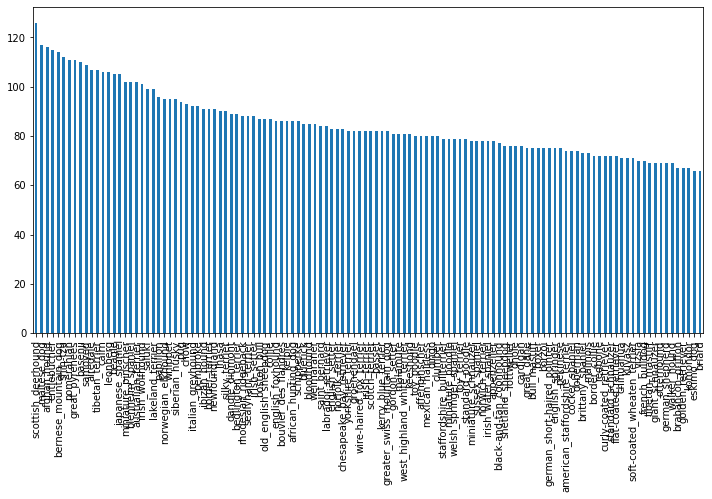

In [19]:
plt.figure(figsize=(12, 6))
labels.breed.value_counts().plot.bar()

In [20]:
labels["id"] = "train/" + labels["id"] + ".jpg"

In [21]:
labels.head()

,id,breed
0,train/000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,train/001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, VGG16

In [35]:
idg = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, validation_split=0.1, 
                         rotation_range=45, horizontal_flip=True)

In [36]:
train_idg = idg.flow_from_dataframe(labels, x_col="id", y_col="breed", target_size=(224, 224), batch_size=128, subset="training")
val_idg   = idg.flow_from_dataframe(labels, x_col="id", y_col="breed", target_size=(224, 224), batch_size=128, subset="validation")

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


In [37]:
vgg_model = tf.keras.applications.vgg16.VGG16()

In [38]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [39]:
for layer in vgg_model.layers:
    layer.trainable = False 

In [40]:
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adagrad
from tensorflow.keras.losses     import categorical_crossentropy

In [41]:
x = vgg_model.layers[-3].output
x = BatchNormalization(trainable=False) (x)
x = Dropout(0.5) (x)
x = Dense(120, activation="softmax")(x)

In [42]:
final_model = tf.keras.models.Model(inputs=vgg_model.input, outputs=x)

In [43]:
for layer in final_model.layers: 
    print(layer.name , layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten False
fc1 False
batch_normalization_1 False
dropout_1 True
dense_1 True


In [44]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [49]:
final_model.compile("adagrad", loss=tf.keras.losses.categorical_crossentropy, metrics=["acc"])
final_model_his = final_model.fit_generator(train_idg, epochs=30, validation_data=val_idg)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
72/72 [==============================] - 144s 2s/step - loss: 18.1667 - acc: 0.0305 - val_loss: 6.5907 - val_acc: 0.1898
Epoch 2/30
72/72 [==============================] - 137s 2s/step - loss: 11.4460 - acc: 0.1109 - val_loss: 4.8484 - val_acc: 0.3170
Epoch 3/30
72/72 [==============================] - 137s 2s/step - loss: 9.2764 - acc: 0.1836 - val_loss: 4.4601 - val_acc: 0.3444
Epoch 4/30
72/72 [==============================] - 137s 2s/step - loss: 8.2566 - acc: 0.2302 - val_loss: 4.0726 - val_acc: 0.4070
Epoch 5/30
72/72 [==============================] - 136s 2s/step - loss: 7.5002 - acc: 0.2683 - val_loss: 3.7689 - val_acc: 0.4188
Epoch 6/30
72/72 [==============================] - 136s 2s/step - loss: 7.0673 - acc: 0.2872 - val_loss: 3.6373 - val_acc: 0.4462
Epoch 7/30
72/72 [==============================] - 135s 2s/step - loss: 6.6848 - acc: 0.3184 - val_loss: 3.5591 - val_acc: 0.4628
Epoch 8/30
72/72 [==============================] - 137s 2s/step - loss: 6.3938 -

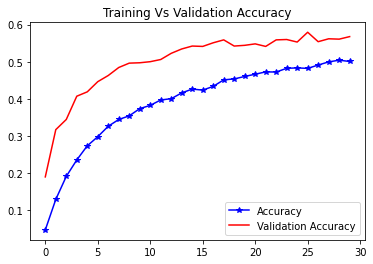

In [50]:
plt.plot(final_model_his.history["acc"],"b*-",label="Accuracy")
plt.plot(final_model_his.history["val_acc"],"r",label="Validation Accuracy")
plt.title('Training Vs Validation Accuracy')
plt.legend()

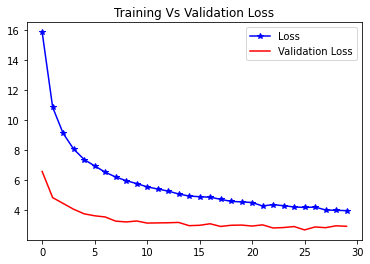

In [51]:
plt.plot(final_model_his.history["loss"],"b*-",label="Loss")
plt.plot(final_model_his.history["val_loss"],"r",label="Validation Loss")
plt.title('Training Vs Validation Loss')
plt.legend()

In [52]:
del final_model
x = vgg_model.layers[-3].output
x = tf.keras.layers.BatchNormalization(trainable=False) (x)
x = tf.keras.layers.Dropout(0.5) (x)
x = tf.keras.layers.Dense(120, activation="softmax")(x)

final_model = tf.keras.models.Model(inputs=vgg_model.input, outputs=x)
final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005), loss=tf.keras.losses.categorical_crossentropy, metrics=["acc"])
final_model_his = final_model.fit_generator(train_idg, epochs=30, validation_data=val_idg)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
72/72 [==============================] - 137s 2s/step - loss: 15.3358 - acc: 0.0854 - val_loss: 3.8851 - val_acc: 0.4501
Epoch 2/30
72/72 [==============================] - 135s 2s/step - loss: 6.5775 - acc: 0.3620 - val_loss: 3.4849 - val_acc: 0.5274
Epoch 3/30
72/72 [==============================] - 135s 2s/step - loss: 5.0558 - acc: 0.4568 - val_loss: 3.1591 - val_acc: 0.5499
Epoch 4/30
72/72 [==============================] - 134s 2s/step - loss: 4.4499 - acc: 0.4986 - val_loss: 3.0108 - val_acc: 0.5675
Epoch 5/30
72/72 [==============================] - 135s 2s/step - loss: 3.9876 - acc: 0.5472 - val_loss: 2.9429 - val_acc: 0.6047
Epoch 6/30
72/72 [==============================] - 135s 2s/step - loss: 3.4206 - acc: 0.5876 - val_loss: 2.9785 - val_acc: 0.6018
Epoch 7/30
72/72 [==============================] - 135s 2s/step - loss: 3.3464 - acc: 0.5917 - val_loss: 3.0222 - val_acc: 0.5988
Epoch 8/30
72/72 [==============================] - 134s 2s/step - loss: 3.0304 - 

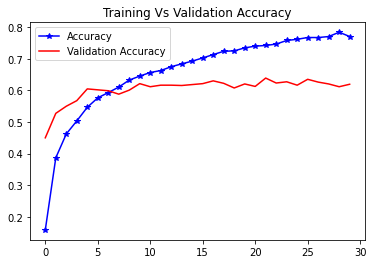

In [53]:
plt.plot(final_model_his.history["acc"],"b*-",label="Accuracy")
plt.plot(final_model_his.history["val_acc"],"r",label="Validation Accuracy")
plt.title('Training Vs Validation Accuracy')
plt.legend()

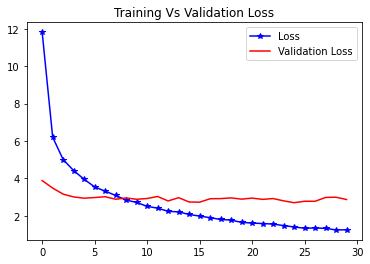

In [54]:
plt.plot(final_model_his.history["loss"],"b*-",label="Loss")
plt.plot(final_model_his.history["val_loss"],"r",label="Validation Loss")
plt.title('Training Vs Validation Loss')
plt.legend()

### VGG, SGD, Dropout 0.3

Epoch 1/10
288/288 [==============================] - 97s 337ms/step - loss: 2.2552 - acc: 0.4905 - val_loss: 1.1992 - val_acc: 0.6614
Epoch 2/10
288/288 [==============================] - 94s 325ms/step - loss: 1.0742 - acc: 0.7035 - val_loss: 1.1244 - val_acc: 0.6820
Epoch 3/10
288/288 [==============================] - 93s 325ms/step - loss: 0.8020 - acc: 0.7593 - val_loss: 1.0951 - val_acc: 0.7084
Epoch 4/10
288/288 [==============================] - 94s 325ms/step - loss: 0.6203 - acc: 0.8047 - val_loss: 1.1365 - val_acc: 0.7114
Epoch 5/10
288/288 [==============================] - 93s 323ms/step - loss: 0.5034 - acc: 0.8368 - val_loss: 1.0933 - val_acc: 0.7143
Epoch 6/10
288/288 [==============================] - 93s 325ms/step - loss: 0.4238 - acc: 0.8601 - val_loss: 1.0705 - val_acc: 0.7221
Epoch 7/10
288/288 [==============================] - 94s 325ms/step - loss: 0.3499 - acc: 0.8847 - val_loss: 1.0463 - val_acc: 0.7211
Epoch 8/10
288/288 [==============================] - 93s 324ms/step - loss: 0.2971 - acc: 0.9007 - val_loss: 1.0972 - val_acc: 0.7153
Epoch 9/10
288/288 [==============================] - 93s 324ms/step - loss: 0.2501 - acc: 0.9201 - val_loss: 1.0951 - val_acc: 0.7182
Epoch 10/10
288/288 [==============================] - 93s 324ms/step - loss: 0.2357 - acc: 0.9229 - val_loss: 1.0782 - val_acc: 0.7172


### VGG, SGD, Dropout 0.5

Epoch 1/10
288/288 [==============================] - 97s 338ms/step - loss: 2.0115 - acc: 0.5627 - val_loss: 1.2906 - val_acc: 0.6703
Epoch 2/10
288/288 [==============================] - 94s 325ms/step - loss: 1.3496 - acc: 0.6729 - val_loss: 1.2731 - val_acc: 0.6859
Epoch 3/10
288/288 [==============================] - 93s 324ms/step - loss: 1.1071 - acc: 0.7189 - val_loss: 1.3088 - val_acc: 0.6918
Epoch 4/10
288/288 [==============================] - 93s 324ms/step - loss: 0.8868 - acc: 0.7645 - val_loss: 1.1902 - val_acc: 0.7045
Epoch 5/10
288/288 [==============================] - 93s 324ms/step - loss: 0.7530 - acc: 0.7868 - val_loss: 1.2589 - val_acc: 0.7172
Epoch 6/10
288/288 [==============================] - 93s 325ms/step - loss: 0.6513 - acc: 0.8092 - val_loss: 1.1751 - val_acc: 0.7241
Epoch 7/10
288/288 [==============================] - 93s 324ms/step - loss: 0.5706 - acc: 0.8308 - val_loss: 1.2395 - val_acc: 0.7250
Epoch 8/10
288/288 [==============================] - 93s 324ms/step - loss: 0.5172 - acc: 0.8388 - val_loss: 1.2310 - val_acc: 0.7114
Epoch 9/10
288/288 [==============================] - 93s 323ms/step - loss: 0.4628 - acc: 0.8568 - val_loss: 1.2077 - val_acc: 0.7280
Epoch 10/10
288/288 [==============================] - 93s 324ms/step - loss: 0.4121 - acc: 0.8638 - val_loss: 1.2070 - val_acc: 0.7339

### VGG, SGD(0.005), Dropout 0.5

Epoch 1/10
288/288 [==============================] - 98s 340ms/step - loss: 7.3447 - acc: 0.2071 - val_loss: 2.2872 - val_acc: 0.4951
Epoch 2/10
288/288 [==============================] - 93s 324ms/step - loss: 2.7564 - acc: 0.4055 - val_loss: 1.7904 - val_acc: 0.5822
Epoch 3/10
288/288 [==============================] - 93s 323ms/step - loss: 2.2900 - acc: 0.4695 - val_loss: 1.5896 - val_acc: 0.6243
Epoch 4/10
288/288 [==============================] - 93s 322ms/step - loss: 1.9500 - acc: 0.5291 - val_loss: 1.4255 - val_acc: 0.6448
Epoch 5/10
288/288 [==============================] - 93s 322ms/step - loss: 1.7500 - acc: 0.5668 - val_loss: 1.3396 - val_acc: 0.6654
Epoch 6/10
288/288 [==============================] - 93s 323ms/step - loss: 1.6118 - acc: 0.5910 - val_loss: 1.2927 - val_acc: 0.6742
Epoch 7/10
288/288 [==============================] - 93s 322ms/step - loss: 1.4624 - acc: 0.6291 - val_loss: 1.2849 - val_acc: 0.6595
Epoch 8/10
288/288 [==============================] - 93s 323ms/step - loss: 1.3763 - acc: 0.6392 - val_loss: 1.2418 - val_acc: 0.6742
Epoch 9/10
288/288 [==============================] - 93s 323ms/step - loss: 1.2695 - acc: 0.6574 - val_loss: 1.2055 - val_acc: 0.6859
Epoch 10/10
288/288 [==============================] - 93s 322ms/step - loss: 1.2065 - acc: 0.6747 - val_loss: 1.1969 - val_acc: 0.6771

### VGG, SGD(0.005), Dropout 0.5

Epoch 1/30
288/288 [==============================] - 97s 337ms/step - loss: 3.3407 - acc: 0.3476 - val_loss: 1.1861 - val_acc: 0.6624
Epoch 2/30
288/288 [==============================] - 93s 324ms/step - loss: 1.5737 - acc: 0.6062 - val_loss: 1.0799 - val_acc: 0.6732
Epoch 3/30
288/288 [==============================] - 93s 324ms/step - loss: 1.2610 - acc: 0.6636 - val_loss: 1.0170 - val_acc: 0.7035
Epoch 4/30
288/288 [==============================] - 93s 324ms/step - loss: 1.0806 - acc: 0.6998 - val_loss: 0.9867 - val_acc: 0.7231
Epoch 5/30
288/288 [==============================] - 93s 324ms/step - loss: 0.9417 - acc: 0.7360 - val_loss: 1.0046 - val_acc: 0.7182
Epoch 6/30
288/288 [==============================] - 93s 324ms/step - loss: 0.8415 - acc: 0.7554 - val_loss: 1.0021 - val_acc: 0.7221
Epoch 7/30
288/288 [==============================] - 94s 326ms/step - loss: 0.7585 - acc: 0.7762 - val_loss: 1.0033 - val_acc: 0.7368
Epoch 8/30
288/288 [==============================] - 93s 324ms/step - loss: 0.6682 - acc: 0.7966 - val_loss: 1.0137 - val_acc: 0.7299
Epoch 9/30
288/288 [==============================] - 93s 324ms/step - loss: 0.6283 - acc: 0.8088 - val_loss: 0.9686 - val_acc: 0.7417
Epoch 10/30
288/288 [==============================] - 93s 323ms/step - loss: 0.5683 - acc: 0.8236 - val_loss: 0.9872 - val_acc: 0.7319

In [ ]:
# How to remove Overfitting 
# 1. Increase the data 
# 2. Decrese the network capacity 
# 3. Introduction of Dropout & BatchNormalization
# 4. Control LR